# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 36kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

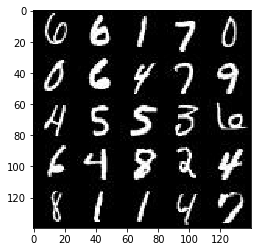

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

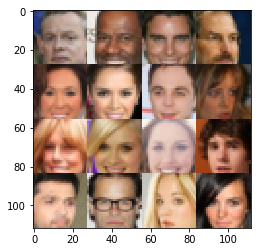

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。

备注:tensor的rank就是其维度。Rank本意是矩阵的秩，不过Tensor Rank和Matrix Rank的意义不太一样，这里就还叫Rank。Tensor Rank的意义看起来更像是维度，比如Rank =1就是向量，Rank=2 就是矩阵了，Rank = 0 就是一个值。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    #输入图像占位符
    input_real = tf.placeholder(dtype=tf.float32,shape=[None,image_width,image_height,image_channels])
    #输入 Z 占位符.列数为z_dim，行数不定。
    input_z = tf.placeholder(dtype=tf.float32,shape=[None,z_dim],name='z_dim')
    #学习速率占位符
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    #tf.variable_scope()用来指定变量的作用域，作为变量名的前缀。返回一个用于定义创建variable（层）的op的上下文管理器。
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        #64个卷积过滤器，卷积窗大小为5x5，步长为2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        relu1 = tf.maximum(alpha * x1, x1)
        dropout1 = tf.nn.dropout(relu1,keep_prob=0.8)
        # 14x14x32
        
        x2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same',kernel_initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        #添加批次归一化层
        bn2 = tf.layers.batch_normalization(x2, trainable=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropout2 = tf.nn.dropout(relu2, keep_prob=0.8)
        # 7x7x128 now
        
        # Flatten层
        #Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。
        flat = tf.reshape(dropout2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)   
    
    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        #is_training:图层是否处于训练模式。在训练模式下，它将积累转入的统计量moving_mean并 
        #moving_variance使用给定的指数移动平均值 decay。当它不是在训练模式，那么它将使用的
        #数值moving_mean和moving_variance。
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(images=logits, size=(28,28))
        # 28x28x3 now
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(images=input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_model_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels = tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # 获取trainable_variables, 分割成生成和鉴别部分 
    t_vars = tf.trainable_variables()
    
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    #从结合tf.GraphKeys.UPDATE_OPS中取出全部变量，生成一个列表
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)  
    #控制计算流图，指定计算顺序：在update_ops操作后运行g_train_opt和d_train_opt。
    with tf.control_dependencies(update_ops):  
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model   建立GANs 模型
    # Number of Images to display
    show_n_images = 25
    
    input_real, input_z, learning_rate_ = model_inputs(image_height=data_shape[1],image_width=data_shape[2],image_channels=data_shape[3],z_dim = z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    index = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                 batch_images = batch_images * 2
                    
                # Sample random noise for G
                 batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                 _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_: learning_rate})
                 _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     learning_rate_: learning_rate})
                 index = index + 1
                
                 if index % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.8092


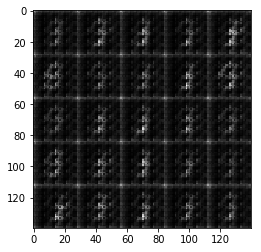

Epoch 1/2... Discriminator Loss: 1.3750... Generator Loss: 0.8058


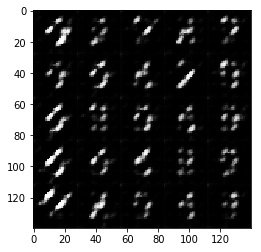

Epoch 1/2... Discriminator Loss: 1.3091... Generator Loss: 0.8662


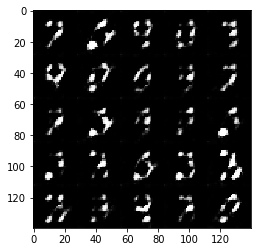

Epoch 1/2... Discriminator Loss: 1.3691... Generator Loss: 0.8075


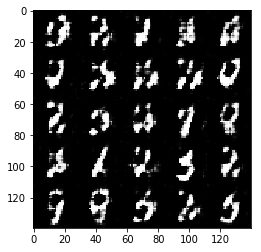

Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 0.8016


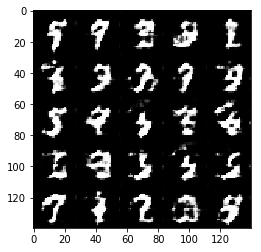

Epoch 2/2... Discriminator Loss: 1.3792... Generator Loss: 0.8399


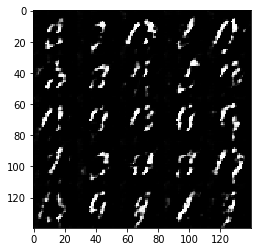

Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 0.8300


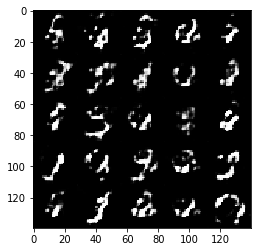

Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 0.8035


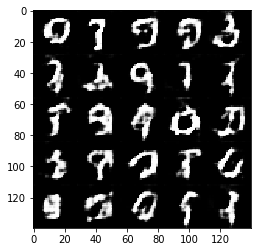

Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.8137


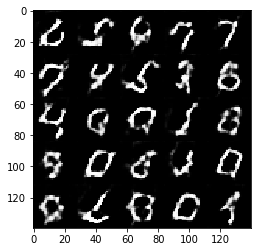

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.8463


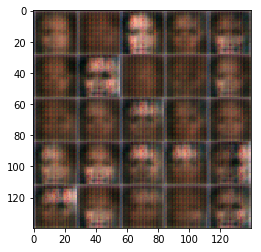

Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.7227


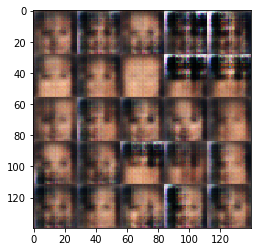

Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7103


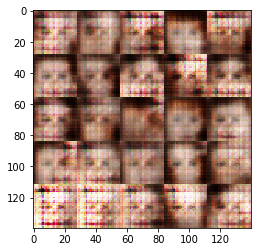

Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.7465


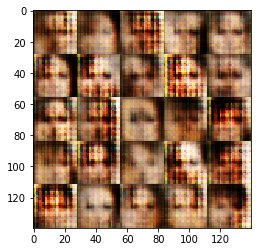

Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7075


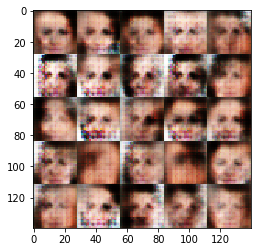

Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7492


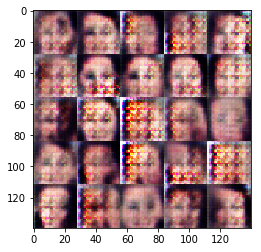

Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.8100


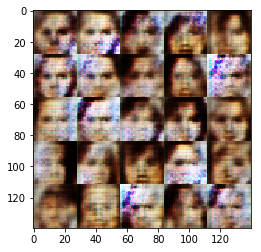

Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9131


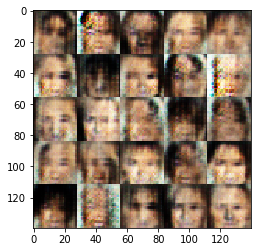

Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.9584


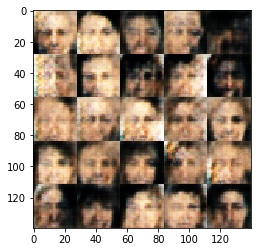

Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.9067


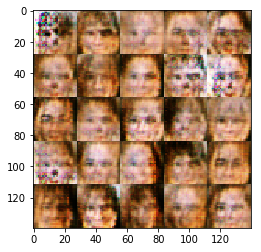

Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8467


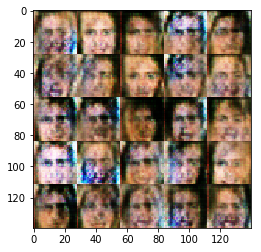

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.8127


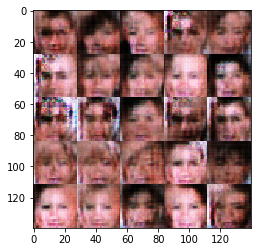

Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8714


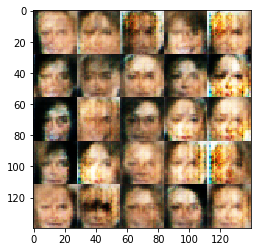

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8335


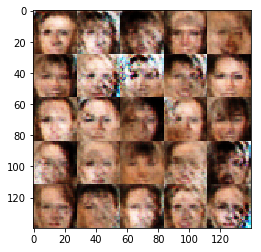

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.8335


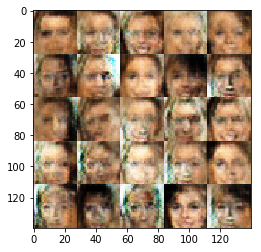

Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.9844


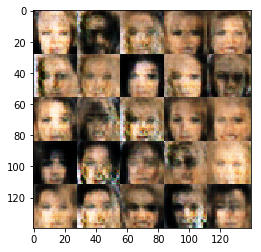

Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7141


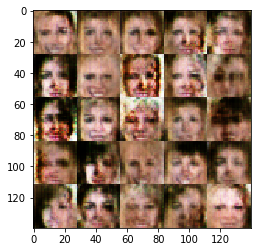

Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 1.0047


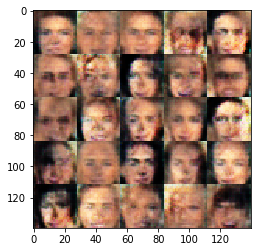

Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.8384


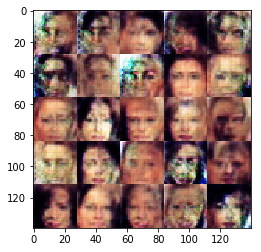

Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7183


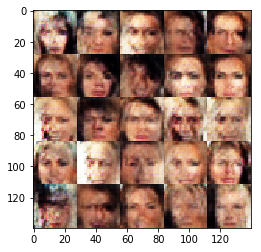

Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.8178


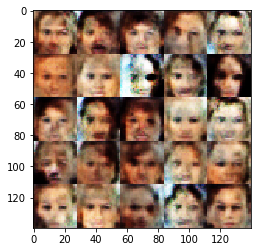

Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.9196


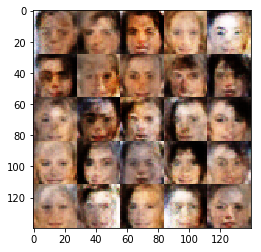

Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.9446


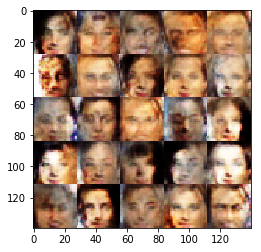

Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6717


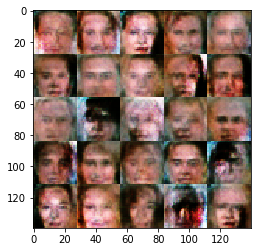

Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.7980


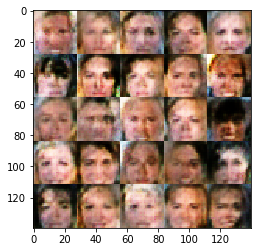

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8168


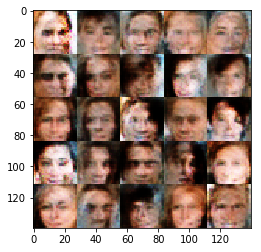

Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.8570


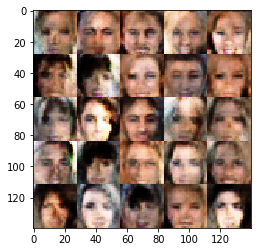

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8329


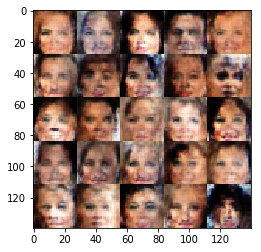

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.8193


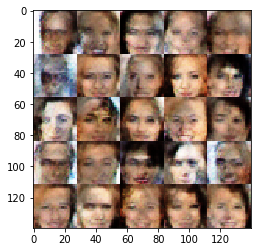

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.8166


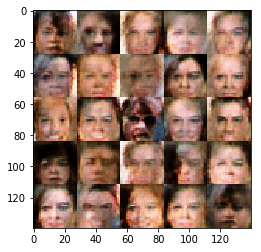

Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7620


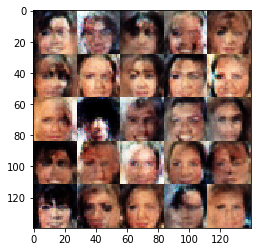

Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6574


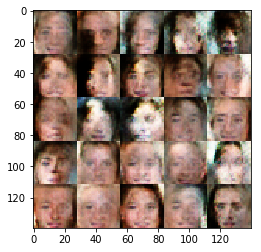

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.8733


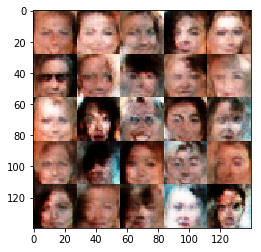

Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.8112


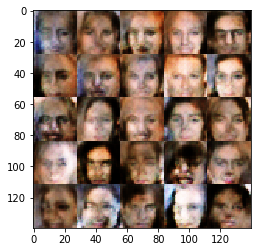

Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.8666


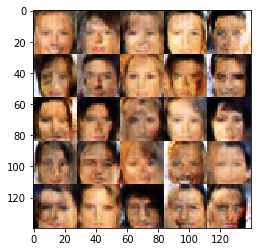

Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7699


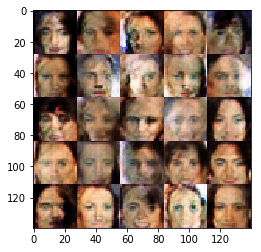

Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7980


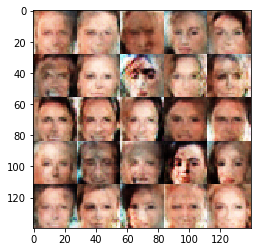

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.7516


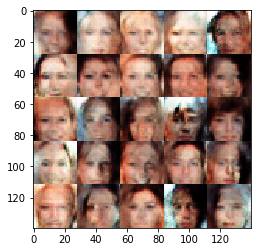

Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7219


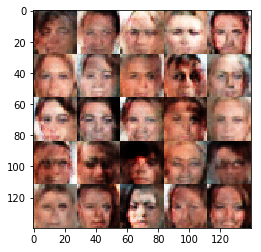

Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.8988


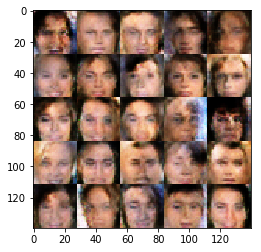

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.7788


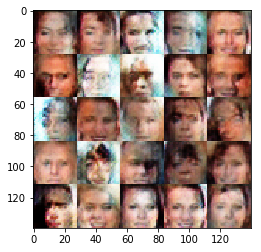

Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.9083


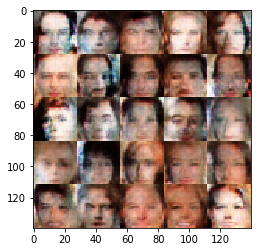

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.7961


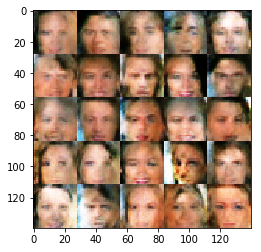

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8854


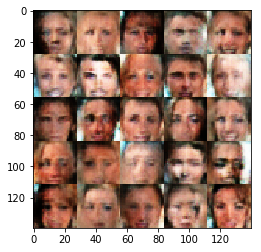

Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.7762


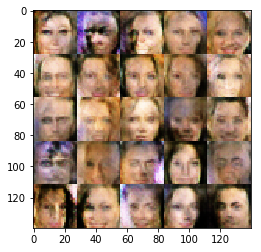

Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8633


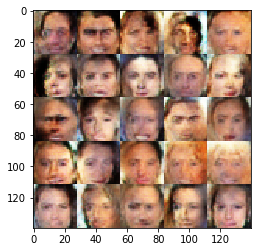

Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8394


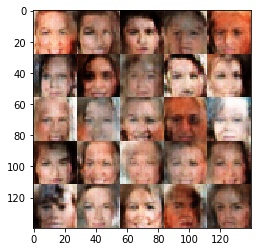

Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7740


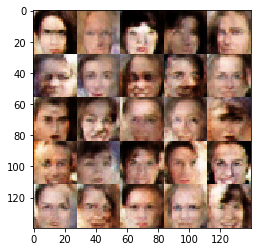

Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7643


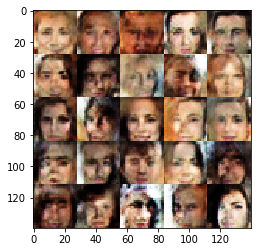

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.8298


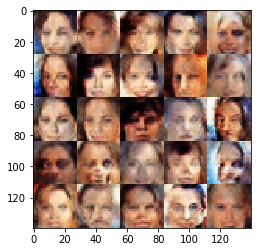

Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7163


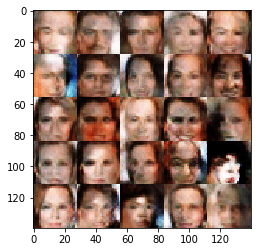

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8723


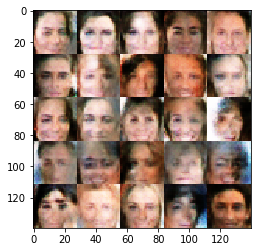

Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.8507


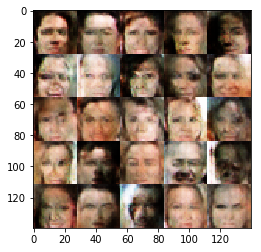

Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7773


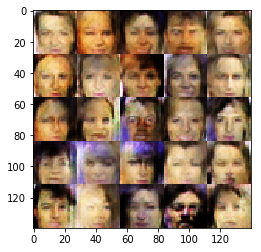

Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7716


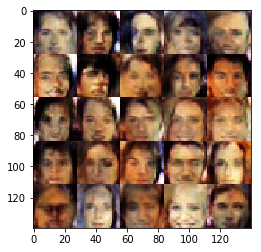

Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7626


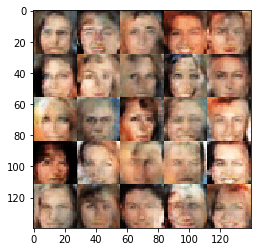

Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8278


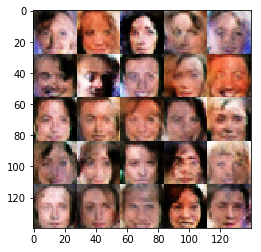

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7761


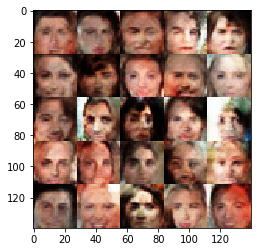

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.8007


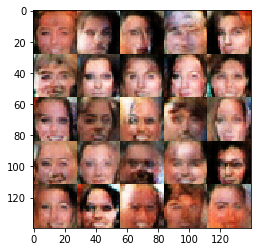

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7100


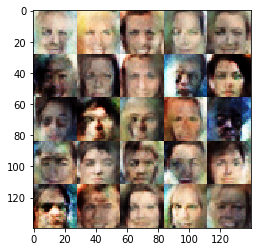

Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7896


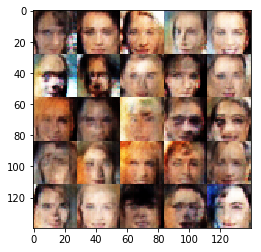

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7080


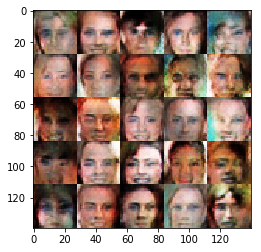

Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.8115


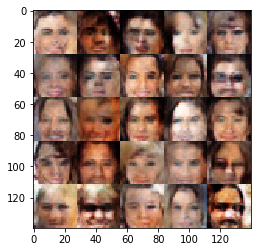

Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7386


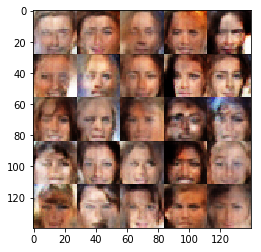

Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.8286


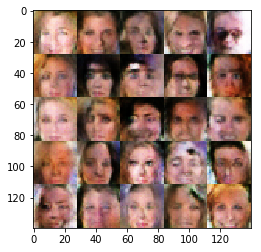

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8781


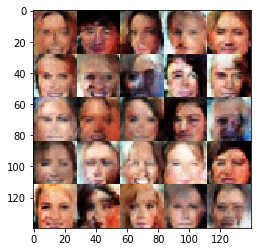

Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7796


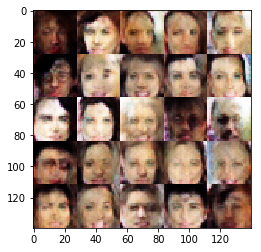

Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6290


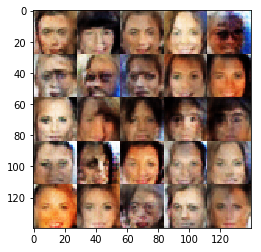

Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7841


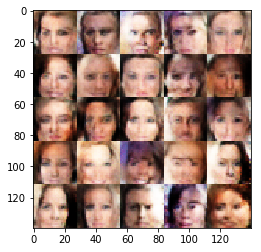

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7702


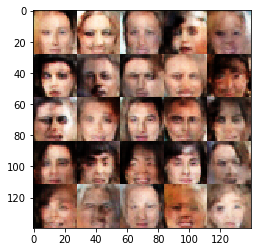

Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.8177


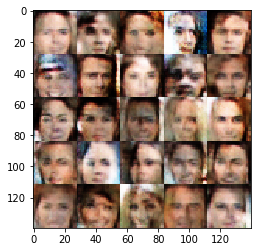

Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8078


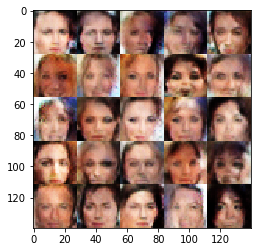

Epoch 1/1... Discriminator Loss: 1.3109... Generator Loss: 0.7754


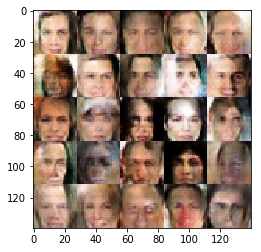

Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8434


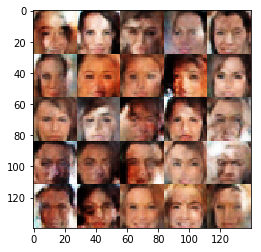

Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8409


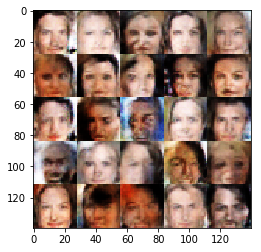

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7943


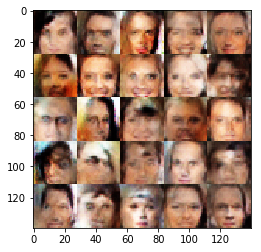

Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7681


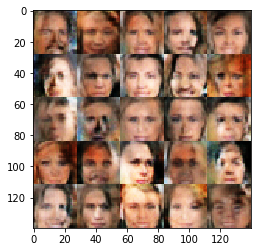

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.7977


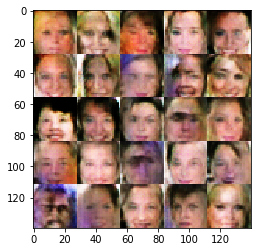

Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.7786


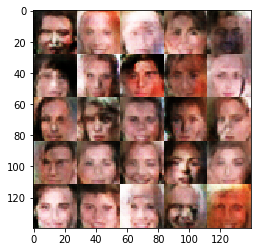

Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.8000


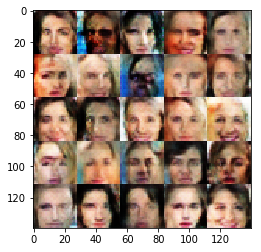

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7365


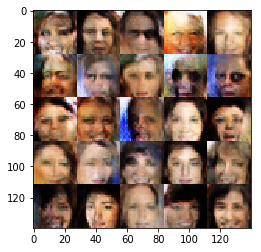

In [ ]:
batch_size = 24
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。